# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

<div style='background-color:rgb(255,240,240); padding:10px;'><span style='color:rgb(150, 0, 0);'><b>yhat was acquired by Alteryx. The link in the markdown cell preding this is broken. <b><br></span><br>Using a search based on a cached version of the page (1) from archive.org, an equivalent page was located at community.alteryx.com (2).<br><br>
(1) A snapshot of the yhat blog post from 2020 (via web.archive.org):<br>
&emsp;   <a href=https://web.archive.org/web/20200812160905/http://blog.yhat.com/posts/customer-segmentation-using-python.html>https://web.archive.org/web/20200812160905/http://blog.yhat.com/posts/customer-segmentation-using-python.html</a><br><br>
(2) An equivalent post available thorugh community.alteryx.com (as of 2022/09/29):<br>
&emsp; <a href=https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442>https://community.alteryx.com/t5/Data-Science/Beginner-s-Guide-to-Customer-Segmentation/ba-p/138442</a><br></div>

In [1]:
import calendar
from dataclasses import dataclass, field
from collections.abc import Sequence, ItemsView
from textwrap import fill
from typing import Union
from numbers import Number
import bisect
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes import Axes
from matplotlib.colors \
    import Colormap, to_rgb, LinearSegmentedColormap, rgb2hex
import seaborn as sns
from country_abbrev import ctry_to_iso_3166_1_a3
from scipy.spatial.distance import cityblock, euclidean
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram, \
    set_link_color_palette
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, AgglomerativeClustering, \
    DBSCAN, KMeans, SpectralClustering
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
VARIETALS = [
    'Pinot Grigio', 'Chardonnay', 'Espumante', 'Champagne', 'Prosecco', 
    'Cabernet Sauvignon', 'Merlot', 'Pinot Noir', 'Malbec'
]
W_COLORS = [to_rgb(_) for _ in 
            ['#ECE9CA', '#D9D49A', '#F1DD46', '#E7B54B', '#EDBF9C', 
             '#911F45', '#682036', '#6A0E27', '#451B29']]
PALETTE = dict(zip(VARIETALS, W_COLORS))
CMAP = LinearSegmentedColormap.from_list(
    'w', list(PALETTE.values()), 500
)
GRADS = [
    LinearSegmentedColormap.from_list(
        f'w_{i}', [np.hstack([g, [_]]) for _ in [0.7, 1]], N=500
    ) for i, g in enumerate(W_COLORS)
]
CAT_CMAP = [
    [0.45, 0.14, 0.29], [0.78, 0.72, 0.71], [0.05, 0.49, 0.89], 
    [0.95, 0.87, 0.27], [0.0, 0.74, 0.58], [0.93, 0.75, 0.61], 
    [0.2, 0.2, 0.6], [0.33, 0.87, 0.47], [0.56, 0.44, 0.41], 
    [0.91, 0.71, 0.29], [0.67, 0.57, 0.42], [0.89, 0.85, 0.54], 
    [0.64, 0.18, 0.26], [0.77, 0.95, 0.55]
]
CAT_HEX = [rgb2hex(CAT_CMAP[i]) for i in [0, 3, 4, 8, 5, 9, 1, -1]]
set_link_color_palette(CAT_HEX)

In [3]:
def hr(divider: str='=', width:int=79, newline:bool=True) -> str:
    '''Return a horizontal rule. Functionally similar to html's <hr>.
    '''
    return (divider * (width//len(divider) + 1))[:width] + int(newline) * '\n'
def est_pop_std(numeric_array: Sequence[Number]) -> float:
    return np.std(numeric_array, ddof=1)
def clear_empty_subplots(data: Sequence, axs: Sequence[Axes]) -> None:
    '''Disable each empty axes for a subplot grid.
    '''
    empty_axs = len(axs) - len(data)
    if empty_axs:
        for r_ind in range(1, empty_axs + 1):
            axs[-1 * r_ind].set_axis_off()
def arr_as_txt(
        arr: Sequence, i_ind: int=0, s_ind: int=0, w: int=70) -> str:
    '''Return an array formatted as a string for readability.
    '''
    a = ', '.join([f'{_}' for _ in arr])
    i_ind, s_ind = i_ind * ' ', s_ind * ' '
    return fill(a, width=w, initial_indent=i_ind, subsequent_indent=s_ind)
def interpret_silh_score(silh_score: float) -> str:
    '''Return a qualitative assessment of the structure identified by
    a clustering operation given its clusters' average silhouette score.
    '''
    i = bisect.bisect([0.26, 0.51, 0.71], silh_score)
    return ['insubstantial', 'weak', 'reasonable', 'strong'][i]
def varietal_legend(palette: dict = PALETTE) -> None:
    fig, ax = plt.subplots(figsize=(0.5, 3))
    for i, (wine, color) in enumerate(palette.items()):
        ax.barh(y=i, width=1, height=0.7, color=color, edgecolor=np.array(color)/1.3)
    ax.set_yticks(range(len(palette)), palette.keys());
    ax.grid(visible=False); ax.set_xticks([]), ax.spines[:].set_color([0]*4)
    ax.tick_params(axis='both', which='both', length=0)
    ax.yaxis.tick_right(); ax.set_xlim([0.2, 0.4])
    plt.show();
def clustering_scatterplot(
        pc_1: ArrayLike, pc_2: ArrayLike, labels: ArrayLike,
        n: int, cmap: object=None, palette: dict=None, ax:Axes=None,
        xlabel: str='PC 1', ylabel: str='PC2', title: str='') -> None:
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.grid(visible=True, zorder=-2); ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0])
    ax.tick_params(axis='both', which='both', length=0)
    if palette is not None:
        color = [palette[label] for label in labels]
    else:
        if cmap is None:
            palette = CAT_CMAP
            color = [palette[label] for label in labels]
        else:
            color = [cmap(label) for label in labels]
    ax.set_facecolor([0.93, 0.93, 0.93])
    ax.scatter(x=pc_1, y=pc_2, zorder=100, color=color)
    ax.set_xlabel(xlabel, labelpad=12); ax.set_ylabel(ylabel, labelpad=12)
    ax.set_yticks(ax.get_yticks(), labels=['' for _ in ax.get_yticks()])
    ax.set_xticks(ax.get_xticks(), labels=['' for _ in ax.get_xticks()])
    if not title:
        title = f'{n} Clusters'
    ax.set_title(title, pad=12)
    plt.tight_layout()
def linkage_matrix(clusterer: BaseEstimator) -> ArrayLike:
    '''Return a linkage matrix for a given agglomerative clusterer.
    '''
    counts = np.zeros(clusterer.children_.shape[0])
    num_labels = len(clusterer.labels_)
    for i, merge in enumerate(clusterer.children_):
        j = 0
        for child_idx in merge:
            if child_idx < num_labels:
                j += 1
            else:
                j += counts[child_idx - num_labels]
        counts[i] = j
    return np.column_stack(
        [clusterer.children_, clusterer.distances_, counts]
    ).astype(float)
def dendrogram_from_linkage(
        linkage_matrix: ArrayLike, ax: Axes=None, **dendrogram_kwargs) -> None:
    '''Plot a dendrogram from given clusterer on a given Axes.
    '''
    if ax is None:
        ax = plt.gca()
    dendrogram(linkage_matrix, ax=ax, **dendrogram_kwargs)
def dendrogram_from_clusterer(
        clusterer: BaseEstimator, ax: Axes=None, **dendrogram_kwargs) -> None:
    dendrogram_from_linkage(
        linkage_matrix(clusterer), ax=ax, **dendrogram_kwargs
    )

In [4]:
@dataclass
class KMeansOption:
    '''A dataclass to streamline K Means clustering operations and provide
    framework for models of a KMeansGroup instance. See KMeansGroup.
    '''
    k: int
    X: ArrayLike
    _kwargs_: dict = field(default_factory=dict)
    labels: ArrayLike = field(init=False)
    clusterer: BaseEstimator = field(init=False)
    inertia: float = field(init=False)
    silhouette_score: float = field(init=False)
    silhouette_samples: ArrayLike = field(init=False)
    info: tuple[int, float, float] = field(init=False)
    scores: tuple[float, float] = field(init=False)
    sil_samples: ArrayLike = field(init=False)
    
    def __post_init__(self):
        self.X = self.X.copy()
        self.clusterer = KMeans(
            n_clusters=self.k, random_state=123, *self._kwargs_
        )
        self.labels = self.clusterer.fit_predict(self.X)
        self.inertia = self.clusterer.inertia_
        self.silhouette_score = silhouette_score(self.X, self.labels)
        self.info = (self.k, self.inertia, self.silhouette_score)
        self.scores = (self.inertia, self.silhouette_score)
        self.silhouette_samples = silhouette_samples(self.X, self.labels)
        self.sil_samples = self.silhouette_samples

@dataclass
class KMeansGroup:
    '''A dataclass to facilitate analysis and evaluation of K Means clustering
    results for given data X clustered at each of a given range of K values.
    '''
    X: ArrayLike
    k_list: list[int] = field(default_factory=list)
    models: dict[int, KMeansOption] = field(default_factory=dict)
    
    def __post_init__(self):
        self.X = self.X.copy()
        if not self.models:
            self.models = {k_: KMeansOption(k_, self.X) for k_ in self.k_list}
        
    def describe() -> str:
        header = f'{f"k":<5}{f"inertia":>14}{f"silhouette":>14}\n{"":-<35}\n'
        table = '\n'.join(
            f'{k:<5}{inertia:>14.3f}{score:>14.3f}' for k, inertia, score 
            in model.info for model in self.models.values()
        )
        return header + table
    
    def sil_subplot_rows(self, ncols: int, cmap: Colormap=None) -> None:
        '''Generate a grid of silhouette plots for each of the values in
        self.k_list. Adapted from code presented at:
            URL(https://scikit-learn.org/stable/auto_examples/cluster
                /plot_kmeans_silhouette_analysis.html)
        '''
        cmap = cm.terrain if cmap is None else cmap
        nrows = len(self.k_list) // ncols + bool(len(self.k_list) % ncols)
        fig, axs = plt.subplots(nrows, ncols, figsize=(12, nrows*4))
        axs = axs.flat
        clear_empty_subplots(self.k_list, axs)
        ax_i, ax_j = 0, range(0, nrows * ncols + 1, ncols)
        for (k, kmm), ax in zip(self.models.items(), axs):
            x_lower = 10
            ax.tick_params(axis='both', which='both', length=0, pad=8)
            ax.set_title(f"K = {k}", pad=8)
            ax.set_facecolor([0.93, 0.93, 0.93])
            ax.grid(color=[0.83, 0.83, 0.83], zorder=-1, alpha=0.5)
            for i in range(k):
                ith_cluster_sil_values = kmm.sil_samples[kmm.labels == i]
                ith_cluster_sil_values.sort()
                size_cluster_i = ith_cluster_sil_values.shape[0]
                x_upper = x_lower + size_cluster_i
                color = cmap(float(i) / k)
                ax.fill_between(
                    np.arange(x_lower, x_upper), 0, ith_cluster_sil_values,
                    facecolor=color, edgecolor=color, alpha=0.75, label=f'{i}',
                    zorder=2
                )
                x_lower = x_upper + 10
            if ax_i in ax_j:
                ax.set_ylabel('Silhouette coefficient value'); ax.set_xlabel('')
                ax.set_yticks(np.arange(-0.1, 0.7, 0.1))
            else:
                ax.set_ylabel(''); ax.set_xlabel(''); 
                ax.set_yticks(np.arange(-0.1, 0.7, 0.1), [''] * 8)
            # The horizontal line for average silhouette score of all the values
            ax.axhline(y=kmm.silhouette_score, color="red", linestyle="--", zorder=4)
            ax.set_ylim([-0.2, 0.6])
            ax.set_xticks([]); ax.spines[:].set_color((1, 1, 1, 0));
            ax_i += 1
        fig.suptitle('Clustering Silhouette Analysis by K Value')
        fig.tight_layout()
        plt.show()
@dataclass
class ClusteringOption:
    '''A dataclass to facilitate comparison of clustering outcomes between
    distinct clustering methods.
    '''
    x: ArrayLike
    x_id: ArrayLike
    id_col: str
    data: pd.DataFrame   
    clusterer: BaseEstimator
    labels: ArrayLike = field(init=False)
    clustering_details: pd.DataFrame = field(init=False)
    avg_silhouette_score: float = field(init=False)

    def __post_init__(self):
        self.labels = self.clusterer.fit_predict(X=self.x)
        if len(set(self.labels)) < 2:
            self.avg_silhouette_score = np.nan
        else:
            self.avg_silhouette_score = silhouette_score(X=self.x, labels=self.labels)
        self.clustering_details = (
            pd.DataFrame({self.id_col: self.x_id, 'cluster_id': self.labels}).merge(
                self.data, how='left', left_on=self.id_col, right_on=self.id_col
            )
        )

@dataclass
class ClusteringOptionGroup:
    x: ArrayLike
    x_id: ArrayLike
    id_col: str
    data: pd.DataFrame
    clusterers: list[BaseEstimator]
    names: list[str]
    options: dict = field(default_factory=dict)
    op_items: ItemsView = field(init=False)
    
    def __post_init__(self):
        for name, clusterer in zip(self.names, self.clusterers):
            self.options[name] = ClusteringOption(
                self.x, self.x_id, self.id_col, self.data, clusterer
            )
        self.op_items = self.options.items()

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

Each worksheet has been saved as a csv file. Code cells containing Pandas read operations are adjusted accordingly.

In [5]:
df_offers = pd.read_csv('WineKMC_0.csv')

### 1b. Explore the data

In [6]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [7]:
df_transactions = pd.read_csv('WineKMC_1.csv')
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [8]:
response_by_offer = df_transactions.pivot_table(
    index='customer_name', columns='offer_id', values='n', fill_value=0
)
response_by_offer.head(3)

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

<span style="color:rgb(10, 100, 140);">What values of $SS$ do you believe represent better clusterings? Why?</span>

There is no universal metric for clustering quality. The quality of clustering achieved by a model is dependent on the nature of the data being modeled. The differences between the sum of squares values of any two arbitrary clusterings of a given dataset is not itself indicative of anything qualitative. Sum of squares is a quantitative distance metric describing the relationship between a group and a vector. In this case, the group is a cluster, and the vector is a centroid. Lower sum of squares values represent tighter clusterings. Optimal clustering is context-dependent.

<span style="color:rgb(10, 100, 140);">Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums). </span>

In [9]:
x_cols = response_by_offer.values
x_names = response_by_offer.index

<span style="color:rgb(10, 100, 140);">Write code that applies the `KMeans` clustering method from scikit-learn to this matrix.</span>

For each value K in the interval `[2, 10]`, perform K Means clustering on the `x_cols` matrix and calculate inertia. Use values to estimate the central tendency of mean inertia for a population of clusters formed at each K.

In [10]:
inertia_at_k = [ # Run KMeans 100 times at each k, recording inertia values
    (k, [KMeans(n_clusters=k).fit(x_cols).inertia_ for _ in range(100)])
    for k in range(2, 11)
]
mean_inertia_at_k, std_inertia_at_k = [
    [(k, func(inertia)) for k, inertia in inertia_at_k] # Calculate aggregates
    for func in [np.mean, est_pop_std]
]
inertia_interval_low, inertia_interval_hi = [ #Calculate confidence interval
    [mean_inertia_at_k[i][1] + c_ * std_inertia_at_k[i][1] 
     for i in range(len(inertia_at_k))]
    for c_ in [-1.96, 1.96]
]

<span style="color:rgb(10, 100, 140);">Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.</span>

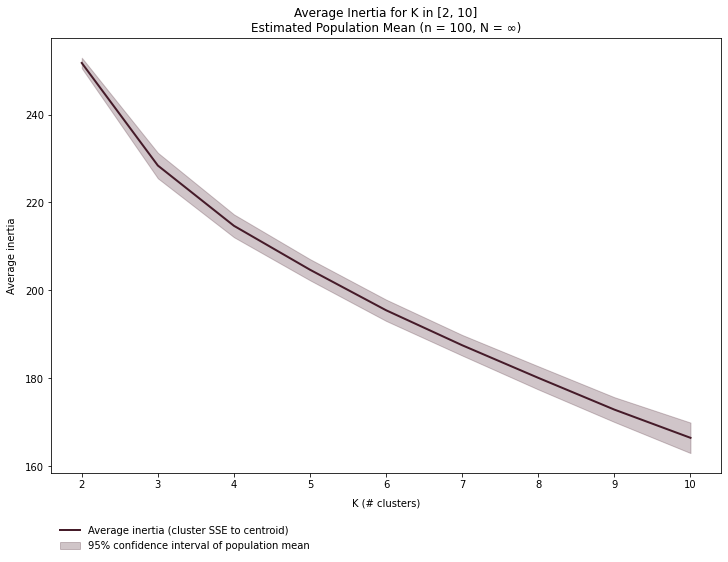

In [11]:
fig, ax = plt.subplots(figsize=(12, 8)); 
ax.set_title('Average Inertia for K in [2, 10]\nEstimated Population Mean (n = 100, N = ∞)');
ax.plot(*zip(*mean_inertia_at_k),  label='Average inertia (cluster SSE to centroid)',
        color=W_COLORS[-1], lw=2)
ax.fill_between(
    list(range(2, 11)), inertia_interval_low, inertia_interval_hi, alpha=0.25,
    label='95% confidence interval of population mean', color=W_COLORS[-1]
)
ax.legend(loc='lower left', bbox_to_anchor=(0, -0.2), edgecolor=(1,1,1))
ax.set_xlabel('K (# clusters)', labelpad=8); ax.set_ylabel('Average inertia', labelpad=8);

No obvious elbow exists in the line plot above. A K value of 3 is selected arbitrarily to generate the required bar plot shown below.

<span style="color:rgb(10, 100, 140);">Make a bar chart showing the number of points in each cluster for k-means under the best $K$.</span>

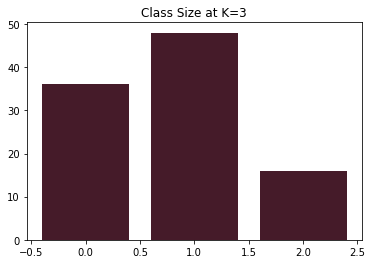

In [12]:
m = KMeans(n_clusters=3); labels = m.fit_predict(x_cols)
fig, ax = plt.subplots()
ax.bar(*np.unique(labels, return_counts=True), color=W_COLORS[-1])
ax.set_title('Class Size at K=3');

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

<span style="color:rgb(10, 100, 140);">Construct a series of silhouette plots like the ones in the article linked above.</span>

Silhouette plots are generated using the `sil_subplot_rows` method of the `KMeansGroup` class.

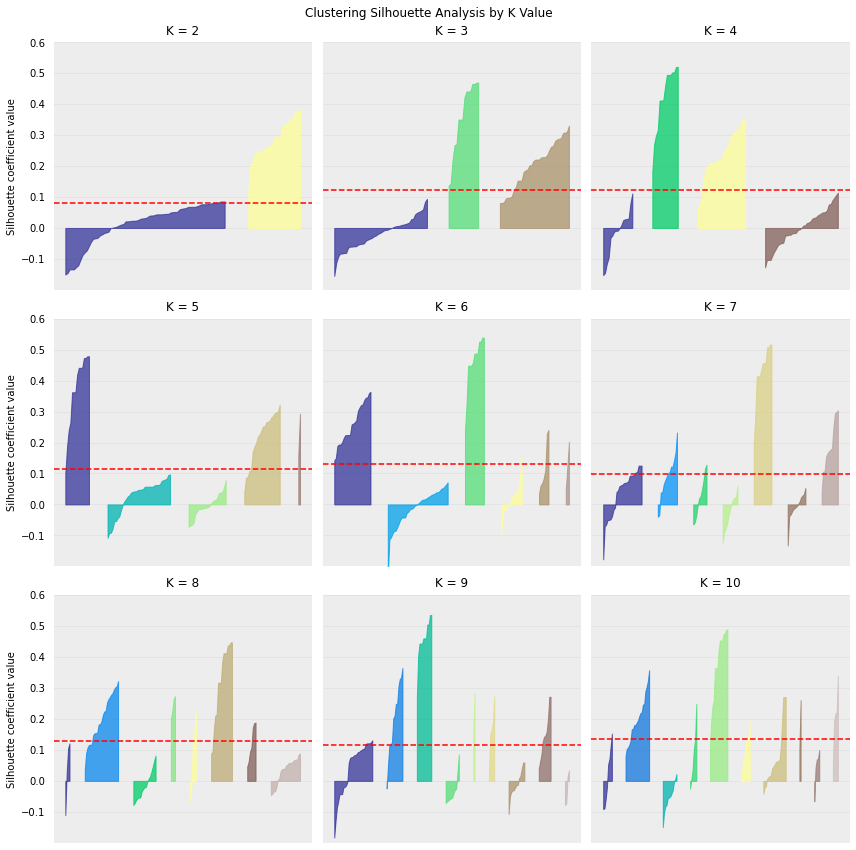

In [13]:
k_m_clusterers = KMeansGroup(x_cols, list(range(2, 11)))
k_m_clusterers.sil_subplot_rows(ncols=3)

<span style="color:rgb(10, 100, 140);">Compute the average silhouette score for each $K$ and plot it.</span>

Calculate the average silhouette scores of 100 K means clustering samples generated for each K in the interval `[2, 10]`.

In [14]:
silh_at_k = [ # Run KMeans 100 times at each k, recording silhouette scores
    (k, [silhouette_score(x_cols, KMeans(n_clusters=k).fit_predict(x_cols))
         for _ in range(100)])
    for k in range(2, 11)
]
mean_silh_at_k, std_silh_at_k = [
    [(k, func(silh)) for k, silh in silh_at_k] # Calculate aggregates
    for func in [np.mean, est_pop_std]
]
silh_interval_low, silh_interval_hi = [ # Calculate confidence interval
    [mean_silh_at_k[i][1] + c_ * std_silh_at_k[i][1] 
     for i in range(len(silh_at_k))]
    for c_ in [-1.96, 1.96]
]

Using values calculated above, plot the estimated population mean of average silhouette score for a population of clustering operations performed at each K in the invlusive interval `[2, 10]`.

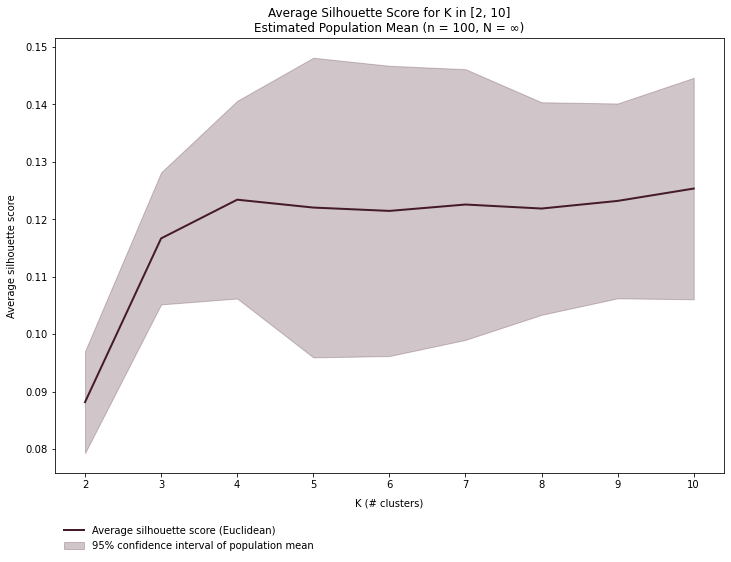

In [15]:
fig, ax = plt.subplots(figsize=(12, 8)); 
ax.set_title('Average Silhouette Score for K in [2, 10]'
             + '\nEstimated Population Mean (n = 100, N = ∞)');
ax.plot(*zip(*mean_silh_at_k),  label='Average silhouette score (Euclidean)',
        color=W_COLORS[-1], lw=2)
ax.fill_between(
    list(range(2, 11)), silh_interval_low, silh_interval_hi, alpha=0.25,
    label='95% confidence interval of population mean', color=W_COLORS[-1]
)
ax.legend(loc='lower left', bbox_to_anchor=(0, -0.2), edgecolor=(1,1,1))
ax.set_xlabel('K (# clusters)', labelpad=8); ax.set_ylabel('Average silhouette score', labelpad=8);

<span style="color:rgb(10, 100, 140);">What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</span>

The plot suggests trying other preprocessing or clustering methods. None of the tested K values returned satisfactory average silhouette scores. No point within the confidence intervals illustrated abbove represents an acceptable silhouette score. <br><br>
Conclusions drawn from the plot above differ from those of the elbow method. The elbow method did not indicate an optimal value of K within the tested interval. The silhouette method indicates none of the tested values of K are optimal for this dataset and clustering technique (given features in their current states). The table shown below reinforces this notion. It is very unlikely that the average cluster of any tested K means clustering operation has been aligned with an inherent division of this dataset at any K of the selected interval.

In [16]:
print('Average silhouette scores for K in [2, 10]:\nSample mean and '
      +'estimated population std at n=100\n-')
print(f'{f"K":<5}{f"n mean silh":>16}{"~ N std silh":>20}'
      + f'{"interpretation":>28}\n{"":-<70}')
for (k, sample_mean), (_, pop_std) in zip(mean_silh_at_k, std_silh_at_k):
    interp = interpret_silh_score(sample_mean)
    print(f'{k:<5}{sample_mean:>16.3f}{pop_std:>20.3f}{interp:>28}')

Average silhouette scores for K in [2, 10]:
Sample mean and estimated population std at n=100
-
K         n mean silh        ~ N std silh              interpretation
----------------------------------------------------------------------
2               0.088               0.005               insubstantial
3               0.117               0.006               insubstantial
4               0.123               0.009               insubstantial
5               0.122               0.013               insubstantial
6               0.121               0.013               insubstantial
7               0.123               0.012               insubstantial
8               0.122               0.009               insubstantial
9               0.123               0.009               insubstantial
10              0.125               0.010               insubstantial


#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

<span style="color:rgb(10, 100, 140);">Use scikit-learn's PCA function to reduce the dimensionality of your clustering data to 2 components.</span>

In [17]:
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(x_cols)
x_col_names = response_by_offer.columns
pca_2 = PCA(n_components=2)
pca_2c = pca_2.fit_transform(x_scaled)
print(f'pca_2c shape: {pca_2c.shape}')

pca_2c shape: (100, 2)


<span style="color:rgb(10, 100, 140);">Create a data frame with the following fields: customer name, cluster id, the two PCA components (label them x and y).</span>

In [18]:
k_list = np.arange(2, 11)
km_w_pca = KMeansGroup(pca_2c, k_list)
cluster_df = pd.DataFrame({
    'customer_name': [name for name in x_names for _ in k_list],
    'x': [pca_2c[:, 0][i] for i in range(len(x_names)) for _ in k_list],
    'y': [pca_2c[:, 1][i] for i in range(len(x_names)) for _ in k_list],
    'k': [k for name in x_names for k in k_list],
    'cluster_id': [
        km_w_pca.models[k].labels[i] 
        for i in range(len(x_names)) for k in k_list
    ]
}).set_index(['customer_name', 'x', 'y', 'k'])
print(
    'K Means Cluster ID by customer'
    + '\n\tfor K in [2, 10]'
    + '\n\tgiven(x = PC1 & y = PC2)'
)
print(35*'-'+'\nsample:')
cluster_df.loc[:x_names[1]]

K Means Cluster ID by customer
	for K in [2, 10]
	given(x = PC1 & y = PC2)
-----------------------------------
sample:


cluster_id
customer_name x         y         k             
Adams         -2.487987 -0.250051 2            1
                                  3            1
                                  4            2
                                  5            2
                                  6            3
                                  7            0
                                  8            4
                                  9            0
                                  10           1
Allen          0.734965 -0.132604 2            0
                                  3            0
                                  4            3
                                  5            0
                                  6            1
                                  7            1
                                  8            1
                                  9            1
                                  10           3

<span style="color:rgb(10, 100, 140);">Plot a scatterplot of the x vs y columns.</span>

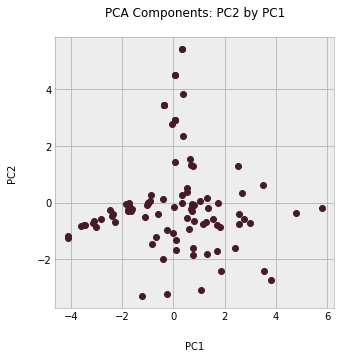

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.tick_params(axis='both', which='both', length=0)
ax.grid(visible=True, zorder=-2); ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0.5])
ax.scatter(pca_2c[:, 0], pca_2c[:, 1], color=W_COLORS[-1], zorder=4)
ax.set_title('PCA Components: PC2 by PC1', pad=20)
ax.set_xlabel('PC1', labelpad=20); ax.set_ylabel('PC2', labelpad=20);
ax.set_facecolor([0.93, 0.93, 0.93])

<span style="color:rgb(10, 100, 140);">Color-code points differently based on cluster ID.</span>

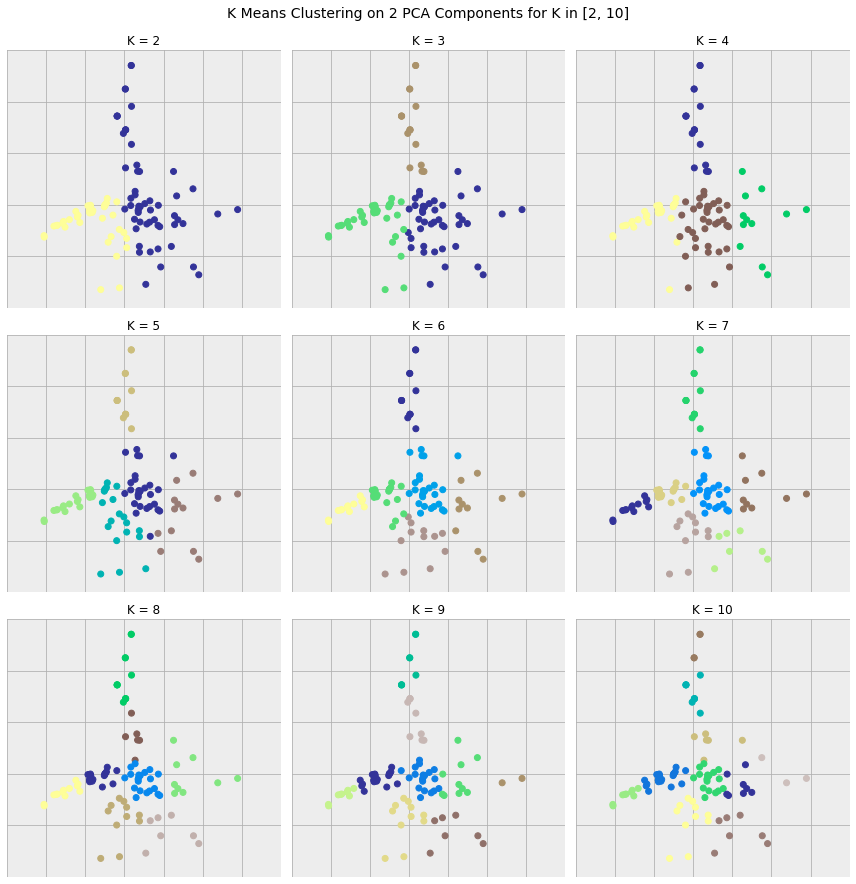

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for (k, model), ax in zip(km_w_pca.models.items(), axs.flat):
    ax.set_facecolor([0.93, 0.93, 0.93])
    ax.scatter(
        x=pca_2c[:, 0], y=pca_2c[:, 1], zorder=100,
        color=cm.terrain(np.array(model.labels)/k)
    )
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_yticks(ax.get_yticks(), labels=['' for _ in ax.get_yticks()])
    ax.set_xticks(ax.get_xticks(), labels=['' for _ in ax.get_xticks()])
    ax.grid(visible=True, zorder=-2); ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0])
    ax.set_title(f'K = {k}')
fig.tight_layout();
fig.suptitle(
    'K Means Clustering on 2 PCA Components for K in [2, 10]', y=1.02, fontsize=14
);

<span style="color:rgb(10, 100, 140);">How do the clusters look?</span>

Colorful.

<span style="color:rgb(10, 100, 140);">Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?</span>

Given what is visible, an optimal value for K cannot be determined.
<br>
<br>
Excepting K = 8 and K = 10, the subplots above all demonstrate comparable clustering quality. The aforementioned exceptions exhibit overlap between the centermost cluster and an adjacent cluster above. This visualization alone provides insufficient basis to declare any value K as the best of a range of values. The above-depicted, two-dimensional feature space generated by principal component analysis is not intuitive to interpret. In isolation, a subjective assessment of clustering quality within this space by visual goodness-of-fit is an academic measure. In this case, the orientation of principal components relative to the original feature space is not particularly revealing (see principal axes below). An accurate description of the relationship between a customer's responses to various offers and their assigned cluster in terms of interpretable features is required to determine whether the clusters assigned at any K are aligned with this dataset's inherent divisions.<br>
<br>
The K selection methods demonstrated in this notebook involved very different visualization methods. An optimal visual representation of clustering quality for a dataset is defined in terms of the intent of clustering. None of these selection and visualization methods is objectively best for all scenarios, but performing K Means clustering on PCA-transformed data is generally efficient and effective.<br>
<br>



<span style="color:rgb(10, 100, 140);"><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</span>

To simplify subsequent selections, index the offers and transactions DataFrames by their respective id columns, `offer_id` and `customer_id`.

In [21]:
offers_by_id = df_offers.copy().set_index('offer_id')
trx_by_customer = df_transactions.copy().set_index('customer_name')

Establish the scope of categorical features by printing unique values.

In [22]:
for feature in ['varietal', 'origin']:
    print(f'{feature}s:\n{arr_as_txt(offers_by_id[feature].unique(), 4, 4)}\n-')

varietals:
    Malbec, Pinot Noir, Espumante, Champagne, Cabernet Sauvignon,
    Prosecco, Chardonnay, Merlot, Pinot Grigio
-
origins:
    France, Oregon, New Zealand, Chile, Australia, South Africa,
    California, Italy, Germany
-


Add origin and varietal abbreviations to enable condensed display of these features.

In [23]:
varietal, origin = [offers_by_id[feature].unique() for feature in ['varietal', 'origin']]
varietal_abbrev = dict(zip(
    varietal,
    ['Mlbc', 'PnNo', 'Espu', 'Chmp', 'Cbrn', 'Prsc', 'Char', 'Mrlo', 'PnGr']
))
origin_abbrev = dict(zip(
    origin, list(map(ctry_to_iso_3166_1_a3, origin))
))
origin_abbrev['Oregon'] = 'USor'
origin_abbrev['California'] = 'USca'
offers_by_id['origin_abbrev'] = offers_by_id.origin.map(origin_abbrev)
offers_by_id['varietal_abbrev'] = offers_by_id.varietal.map(varietal_abbrev)

Map each varietal to an effervescence in `{still, sparkling}` and a color in `{red, white}`.

In [24]:
varietal = offers_by_id.varietal.unique()
sparkling = {v: 'sparkling' for v in ['Espumante', 'Champagne', 'Prosecco']}
effervescence = {v: sparkling.get(v, 'still') for v in varietal}
red = {v: 'red' for v in ['Pinot Noir', 'Cabernet Sauvignon', 'Merlot']}
wine_color = {v: red.get(v, 'white') for v in varietal}
for feat, feat_map in zip(['color', 'effervescence'], [wine_color, effervescence]):
    offers_by_id.loc[:, feat] = offers_by_id.loc[:, 'varietal'].map(feat_map)
offers_by_id['white'] = offers_by_id.color.str.startswith('w')
offers_by_id['red'] = offers_by_id.color.str.startswith('r')

Generate a `season` feature using month information from the existing `campaign` feature.

In [25]:
months = calendar.month_name[1:]
seasons = np.hstack([
    np.repeat(s, 3) for s in 'winter spring summer fall'.split()
])
seasons = {
    month: season for month, season in zip(
        [months[-1]] + months[:-1], seasons
    )
}
offers_by_id.loc[:, 'season'] = offers_by_id.loc[:, 'campaign'].map(seasons)

Create a DataFrame combining offer and transaction information.

In [26]:
offer_responses = trx_by_customer.merge(
    offers_by_id, how='left', left_on='offer_id', right_index=True
)

Generate visualizations of total offers by category for the `region` and `varietal` features.

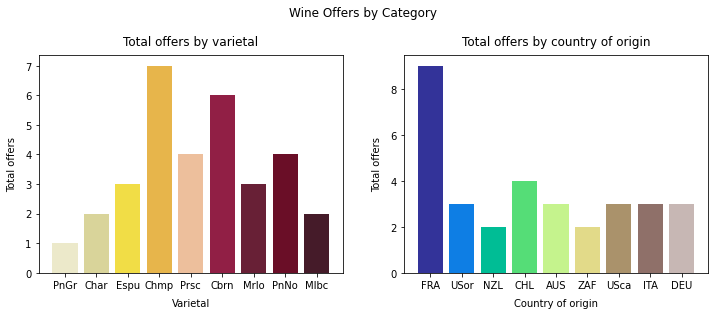

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
var_counts = offers_by_id.varietal_abbrev.value_counts(sort=False)
orig_counts = offers_by_id.origin_abbrev.value_counts(sort=False)
for x, v in enumerate(VARIETALS):
    ax[0].bar(x=x, height=var_counts.loc[varietal_abbrev[v]], color=W_COLORS[x])
ax[0].set_xticks(range(len(VARIETALS)), [varietal_abbrev[v] for v in VARIETALS]);
ax[0].set_title('Total offers by varietal', pad=10)
ax[0].set_ylabel('Total offers', labelpad=8); ax[0].set_xlabel('Varietal', labelpad=8)
for x, o, in enumerate(origin_abbrev.values()):
    ax[1].bar(x=x, height=orig_counts.loc[o], color=cm.terrain(x/len(origin_abbrev)))
ax[1].set_xticks(range(len(origin_abbrev)), list(origin_abbrev.values()))
ax[1].set_title('Total offers by country of origin', pad=10)
ax[1].set_ylabel('Total offers', labelpad=8); ax[1].set_xlabel('Country of origin', labelpad=8)
fig.suptitle('Wine Offers by Category', y=1.05);

Generate plots of total orders by category for the same features.

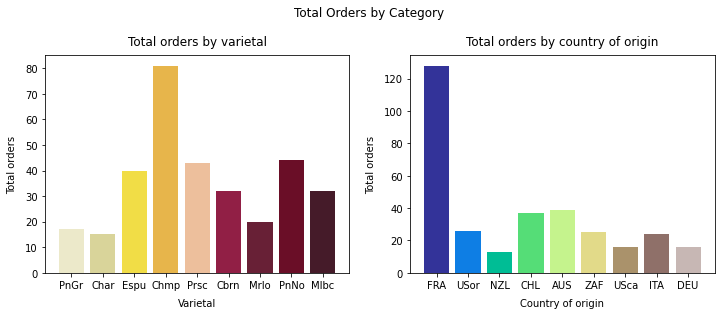

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
orders_by_var = offer_responses.groupby(['varietal_abbrev']).n.sum()
orders_by_ori = offer_responses.groupby(['origin_abbrev']).n.sum()
for x, v in enumerate(VARIETALS):
    ax[0].bar(x=x, height=orders_by_var.loc[varietal_abbrev[v]], color=W_COLORS[x])
ax[0].set_xticks(range(len(VARIETALS)), [varietal_abbrev[v] for v in VARIETALS]);
ax[0].set_title('Total orders by varietal', pad=10)
ax[0].set_ylabel('Total orders', labelpad=8); ax[0].set_xlabel('Varietal', labelpad=8)
for x, o, in enumerate(origin_abbrev.values()):
    ax[1].bar(x=x, height=orders_by_ori.loc[o], color=cm.terrain(x/len(origin_abbrev)))
ax[1].set_xticks(range(len(origin_abbrev)), list(origin_abbrev.values()))
ax[1].set_title('Total orders by country of origin', pad=10)
ax[1].set_ylabel('Total orders', labelpad=8); ax[1].set_xlabel('Country of origin', labelpad=8)
fig.suptitle('Total Orders by Category', y=1.05);

Generate similar plots for the `min_qty` and `discount` features.

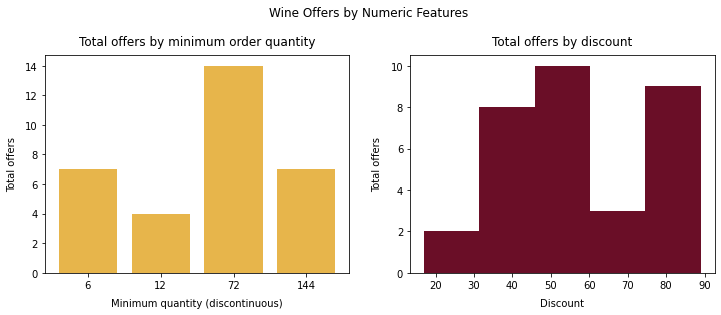

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
qty = sorted(offers_by_id.min_qty.unique())
q_counts = offers_by_id.min_qty.value_counts()
for x, q in enumerate(qty):
    axs[0].bar(x=x, height=q_counts.loc[q], color=W_COLORS[3])
axs[0].set_xticks(range(len(qty)), qty)
axs[0].set_title('Total offers by minimum order quantity', pad=10)
axs[1].hist(offers_by_id.discount, bins=5, color=W_COLORS[-2])
axs[1].set_title('Total offers by discount', pad=10)
for ax, xlabel in zip(axs.flat, ['Minimum quantity (discontinuous)', 'Discount']):
    ax.set_ylabel('Total offers', labelpad=8); ax.set_xlabel(xlabel, labelpad=8)
fig.suptitle('Wine Offers by Numeric Features', y=1.05);

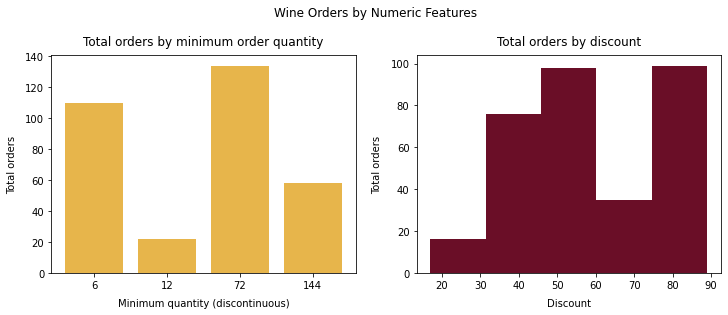

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
orders_by_min_qty = offer_responses.min_qty.value_counts().reindex(qty, fill_value=0)
for x, q in enumerate(qty):
    axs[0].bar(x=x, height=orders_by_min_qty.loc[q], color=W_COLORS[3])
axs[0].set_xticks(range(len(qty)), qty)
axs[0].set_title('Total orders by minimum order quantity', pad=10)
axs[1].hist(offer_responses.discount, bins=5, color=W_COLORS[-2])
axs[1].set_title('Total orders by discount', pad=10)
for ax, xlabel in zip(axs.flat, ['Minimum quantity (discontinuous)', 'Discount']):
    ax.set_ylabel('Total orders', labelpad=8); ax.set_xlabel(xlabel, labelpad=8)
fig.suptitle('Wine Orders by Numeric Features', y=1.05);

Print offer details by month and season to facilitate temporal analysis of clusters at periods of 1 and 3 months.

In [31]:
ses = 'winter spring summer fall'.split()
for period, col, name in zip([months, ses], ['campaign', 'season'], ['Month', 'Season']):
    var_ct_by_p = [
        offers_by_id[offers_by_id[col]==p]
        .varietal.value_counts().reindex(VARIETALS, fill_value='-')
        for p in period
    ]
    reg_ct_by_p = [
        offers_by_id[offers_by_id[col]==p]
        .origin.value_counts().reindex(origin, fill_value='-')
        for p in period
    ]
    print(f'Offer details by {name.lower()}\n{hr("-", newline=False)}')
    print(f'{"varietal":<18}{"".join(f"{p.title()[:3]:>5}" for p in period)}')
    for varietal in VARIETALS:
        print(f'{varietal:<18}{"".join(f"{_.loc[varietal]:>5}" for _ in var_ct_by_p)}')
    print('-')
    print(f'{"origin":<18}{"".join(f"{p.title()[:3]:>5}" for p in period)}')
    for reg in offers_by_id.origin.unique():
        print(f'{reg:<18}{"".join(f"{_.loc[reg]:>5}" for _ in reg_ct_by_p)}')
    print('-')

Offer details by month
-------------------------------------------------------------------------------
varietal            Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
Pinot Grigio          -    -    -    -    -    -    -    -    -    -    1    -
Chardonnay            -    -    -    1    -    -    -    -    1    -    -    -
Espumante             -    1    1    -    -    -    1    -    -    -    -    -
Champagne             -    1    -    -    1    -    1    2    -    1    -    1
Prosecco              -    -    2    1    1    -    -    -    -    -    -    -
Cabernet Sauvignon    -    1    -    -    -    1    -    1    -    1    1    1
Merlot                -    -    -    -    1    2    -    -    -    -    -    -
Pinot Noir            1    -    -    -    -    -    1    -    1    1    -    -
Malbec                1    -    -    -    -    -    -    -    -    -    -    1
-
origin              Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
France                2   

This dataset is too sparse over any business-relevant periods to allow meaningful temporal analysis.

Create a DataFrame combining clustering outcomes with customer transactions and offer details.

In [32]:
offer_cols = offers_by_id.columns
cluster_details = {'k': [], 'cluster_id':[], 'customer_name': []}
cluster_details.update({col:[] for col in offer_cols})
for k, model in km_w_pca.models.items():
    for cluster_id in range(model.k):
        customers = x_names[model.labels == cluster_id]
        c_offers = trx_by_customer.loc[customers].offer_id
        num_offers = trx_by_customer.loc[customers].offer_id.shape[0]
        c_offer_details = {
            'k': [k] * num_offers, 'cluster_id': [cluster_id] * num_offers,
            'customer_name': list(c_offers.index)
        }
        for col in offer_cols:
            c_offer_details[col] = [
                offers_by_id.loc[offer, col] for offer in c_offers.values
            ]
        for column, values in c_offer_details.items():
            cluster_details[column].extend(values)
cluster_details = pd.DataFrame(cluster_details)

Generate a table of aggregates to facilitate cluster comparison in terms of central tendencies and value counts of numeric and categorical features for each cluster formed at each value K.

In [33]:
by_pct = ' by % total orders'
print(
    f'Clustering Assessment Legend\n' + 70*'-' + '\nM min q: '
    + 'Median order minimum qty\nM disc:  Median offer discount\n'
    + 'spark:   % of total wines - sparkling\n'
    + 'red, white: % total orders by color'
)
cluster_details.groupby(['k', 'cluster_id']).agg({
    'min_qty': lambda min_q: np.median(min_q).astype(int), 
    'discount': lambda disc: np.median(disc).round(2), 
    'varietal': lambda vrtl: ', '.join(
        f'{varietal_abbrev[i]:<5} {100*v:>3.0f}%' 
        for i, v in vrtl.value_counts(normalize=True)[:2].iteritems()
    ),
    'origin': lambda orig: ', '.join(
        f'{origin_abbrev[i]:<4} {100*v:>3.0f}%'
        for i, v in orig.value_counts(normalize=True)[:2].iteritems()
    ),
    'season': lambda season: ', '.join(
        f'{i[:2]:<4}{100*v:>3.0f}%'
        for i, v in season.value_counts(normalize=True, sort=False)
        .reindex(['spring', 'summer', 'winter', 'fall'], fill_value=0)
        .iteritems()
    ),
    'effervescence': lambda eff: str(round(100*(eff=='sparkling').mean())) + '%',
    'white': lambda w: str(round(100*np.mean(w))) + '%',
    'red': lambda r: str(round(100*np.mean(r))) + '%'
}).rename(columns={
    'min_qty': 'M min q', 'discount': 'M disc',
    'varietal': f'varietal{by_pct}', 'origin': f'origin{by_pct}',
    'season': f'season{by_pct}', 'effervescence': 'spark',
})

Clustering Assessment Legend
----------------------------------------------------------------------
M min q: Median order minimum qty
M disc:  Median offer discount
spark:   % of total wines - sparkling
red, white: % total orders by color


M min q  M disc varietal by % total orders  \
k  cluster_id                                               
2  0                72    59.0     Chmp   31%, PnNo   22%   
   1                 6    50.0     Espu   31%, Prsc   20%   
3  0                72    63.0     Chmp   39%, Cbrn   18%   
   1                 6    50.0     Espu   31%, Prsc   22%   
   2                72    47.0     PnNo   88%, Prsc    2%   
4  0                72    47.0     PnNo   88%, Prsc    2%   
   1                72    61.0     Chmp   28%, Cbrn   26%   
   2                 6    50.0     Espu   33%, Prsc   20%   
   3                72    63.0     Chmp   46%, Prsc   15%   
5  0                72    63.0     Chmp   35%, Cbrn   15%   
   1                72    52.0     Chmp   43%, Espu   27%   
   2                 6    50.0     Espu   31%, Mlbc   23%   
   3                12    34.0                 PnNo  100%   
   4                72    63.0     Chmp   34%, Cbrn   25%   
6  0                12    34.0                 PnNo  100%   
   1                72    63.0     Chmp   33%, Cbrn   16%   
   2                 6    50.0     Espu   35%, Prsc   24%   
   3                 6    50.0     Espu   31%, Mlbc   22%   
   4                72    63.0     Chmp   29%, Cbrn   29%   
   5                72    63.0     Chmp   60%, Prsc   23%   
7  0                 6    50.0     Espu   31%, Mlbc   22%   
   1                72    63.0     Chmp   34%, Cbrn   17%   
   2                12    34.0                 PnNo  100%   
   3                72    63.5     Chmp   50%, Prsc   25%   
   4                 6    50.0     Espu   33%, Prsc   19%   
   5                72    59.0     Chmp   27%, Cbrn   25%   
   6                72    52.0     Chmp   47%, Espu   28%   
8  0                 6    50.0     Espu   33%, Prsc   19%   
   1                72    63.0     Chmp   39%, Cbrn   16%   
   2                12    34.0                 PnNo  100%   
   3                72    59.0     Chmp   27%, Cbrn   25%   
   4                 6    50.0     Espu   31%, Mlbc   22%   
   5                72    52.0     Chmp   47%, Espu   28%   
   6                72    71.0     PnNo   43%, Cbrn   21%   
   7                72    63.5     Chmp   50%, Prsc   25%   
9  0                 6    50.0     Espu   33%, PnGr   22%   
   1                72    63.0     Chmp   40%, Cbrn   20%   
   2                12    47.0                 PnNo  100%   
   3                72    57.0     Chmp   29%, Cbrn   16%   
   4                 6    50.0     Espu   32%, Mlbc   19%   
   5                72    52.0     Chmp   47%, Espu   28%   
   6                72    61.0     Cbrn   38%, Chmp   25%   
   7                72    63.5     Chmp   50%, Prsc   25%   
   8                72    56.0     PnNo   74%, Prsc    5%   
10 0                72    59.0     Chmp   30%, Cbrn   22%   
   1                 6    52.0     Espu   31%, PnGr   21%   
   2                12    34.0                 PnNo  100%   
   3                72    63.0     Chmp   42%, Cbrn   18%   
   4                 6    50.0     Espu   32%, Mlbc   19%   
   5                72    52.0     Chmp   47%, Espu   28%   
   6                72    57.5     PnNo   33%, Prsc   17%   
   7                12    47.0                 PnNo  100%   
   8                72    63.5     Chmp   50%, Prsc   25%   
   9                72    61.0     Chmp   27%, Cbrn   27%   

              origin by % total orders  \
k  cluster_id                            
2  0              FRA   40%, CHL   14%   
   1              FRA   38%, ZAF   17%   
3  0              FRA   45%, CHL   17%   
   1              FRA   37%, AUS   17%   
   2              ITA   29%, AUS   29%   
4  0              ITA   29%, AUS   29%   
   1              FRA   35%, CHL   19%   
   2              FRA   37%, AUS   18%   
   3              FRA   49%, CHL   14%   
5  0              FRA   53%, CHL   14%   
   1              FRA   32%, ZAF   14%   
   2              FRA   44%, AUS   17%   
   3      

For each value K, calculate cluster centroid locations in the original feature space. For each cluster, sort features in ascending order by average member distance to centroid.

In [34]:
cluster_features = [
    col for col in cluster_details.columns if not col.endswith('abbrev')
    and col not in ['k', 'cluster_id', 'customer_name', 'red', 'white', 'campaign']
]
k_cl_ind = pd.MultiIndex.from_arrays(
    [np.hstack([np.repeat(k, k) for k in k_list]), np.hstack([np.arange(k) for k in k_list])],
    names=['k', 'cluster_id']
)
cdf = cluster_details.set_index(['k', 'cluster_id'])
centroid_rmse = pd.DataFrame(index=k_cl_ind, columns=cluster_features)
centroid_mae = pd.DataFrame(index=k_cl_ind, columns=cluster_features)
for k in k_list:
    for cluster_id in range(k):
        for feature in cluster_features:
            if pd.api.types.is_numeric_dtype(cdf[feature]):
                feat_sub = cdf[['customer_name', feature]].copy()
                min_max = MinMaxScaler()
                feat_sub.loc[:, feature] = min_max.fit_transform(feat_sub[[feature]])
                feat_sub = feat_sub.loc[(k, cluster_id)]
                by_member = feat_sub.groupby(['customer_name'])[feature].mean()
                cluster_mean = by_member.mean()
                if cluster_mean == 0:
                    continue
                cluster_rmse = np.sqrt(np.mean((by_member - cluster_mean)**2))
                cluster_mae = np.mean(abs(by_member - cluster_mean))
            else:
                feat_sub = cdf[['customer_name', feature]].copy()
                vals = feat_sub[feature].unique()
                for v in vals:
                    feat_sub[v] = (feat_sub[feature] == v).astype(int)
                feat_sub.drop(columns=feature, inplace=True)
                by_member = feat_sub.groupby(['customer_name']).mean()
                cluster_mean = by_member.mean()
                cat_error = by_member - cluster_mean
                cluster_mae = (abs(cat_error)).mean().mean()
                cluster_rmse = (cat_error**2).mean().mean()**0.5
            for df, metric in zip([centroid_mae, centroid_rmse], [cluster_mae, cluster_mae]):
                df.loc[(k, cluster_id), feature] = metric
centroid_rmse, centroid_mae = centroid_rmse.convert_dtypes(), centroid_mae.convert_dtypes()
feature_significance = pd.DataFrame(index=k_cl_ind, columns=['features by MAE to centroid'])
for ind, r in centroid_mae.iterrows():
    k, cl = ind
    row = r.dropna().astype(float)
    feat_sig = sorted(row.index, key=row.get)
    feature_significance.loc[(k, cl), 'features by MAE to centroid'] = feat_sig
feature_significance

features by MAE to centroid
k  cluster_id                                                   
2  0           [origin, discount, varietal, min_qty, past_pea...
   1           [discount, origin, min_qty, varietal, past_pea...
3  0           [discount, origin, varietal, min_qty, past_pea...
   1           [min_qty, discount, origin, varietal, past_pea...
   2           [past_peak, origin, discount, varietal, min_qt...
4  0           [past_peak, origin, discount, varietal, min_qt...
   1           [min_qty, discount, origin, varietal, past_pea...
   2           [min_qty, discount, origin, varietal, past_pea...
   3           [discount, origin, varietal, min_qty, season, ...
5  0           [origin, discount, varietal, min_qty, season, ...
   1           [discount, origin, varietal, min_qty, season, ...
   2           [discount, origin, varietal, past_peak, season...
   3           [discount, origin, varietal, min_qty, season, ...
   4           [min_qty, discount, origin, past_peak, varieta...
6  0           [discount, origin, varietal, min_qty, season, ...
   1           [origin, discount, varietal, min_qty, season, ...
   2           [min_qty, origin, discount, varietal, season, ...
   3           [discount, past_peak, origin, varietal, season...
   4           [min_qty, discount, origin, varietal, past_pea...
   5           [discount, past_peak, origin, min_qty, varieta...
7  0           [discount, past_peak, origin, varietal, season...
   1           [origin, discount, varietal, min_qty, season, ...
   2           [discount, origin, varietal, min_qty, season, ...
   3           [discount, min_qty, past_peak, origin, varieta...
   4           [min_qty, origin, discount, varietal, season, ...
   5           [min_qty, discount, origin, varietal, past_pea...
   6           [discount, min_qty, origin, varietal, past_pea...
8  0           [min_qty, origin, discount, varietal, season, ...
   1           [origin, discount, varietal, min_qty, season, ...
   2           [discount, origin, varietal, min_qty, season, ...
   3           [min_qty, discount, origin, varietal, past_pea...
   4           [discount, past_peak, origin, varietal, season...
   5           [discount, min_qty, origin, varietal, past_pea...
   6           [origin, varietal, min_qty, season, discount, ...
   7           [discount, min_qty, past_peak, origin, varieta...
9  0           [min_qty, discount, origin, varietal, season, ...
   1           [origin, discount, varietal, min_qty, season, ...
   2           [discount, origin, varietal, min_qty, season, ...
   3           [discount, min_qty, origin, varietal, past_pea...
   4           [discount, past_peak, origin, varietal, season...
   5           [discount, min_qty, origin, varietal, past_pea...
   6           [min_qty, past_peak, discount, origin, varieta...
   7           [discount, min_qty, past_peak, origin, varieta...
   8           [past_peak, origin, varietal, min_qty, discoun...
10 0           [discount, min_qty, origin, varietal, past_pea...
   1           [min_qty, discount, origin, varietal, season, ...
   2           [discount, origin, varietal, season, min_qty, ...
   3           [origin, varietal, discount, min_qty, season, ...
   4           [discount, past_peak, origin, varietal, season...
   5           [discount, min_qty, origin, varietal, past_pea...
   6           [origin, varietal, min_qty, discount, season, ...
   7           [min_qty, discount, origin, varietal, season, ...
   8           [discount, min_qty, past_peak, origin, varieta...
   9           [min_qty, discount, past_peak, origin, varieta...

Plot the ratio of total orders by varietal for each cluster formed at each K value in the interval `[2, 10]`.

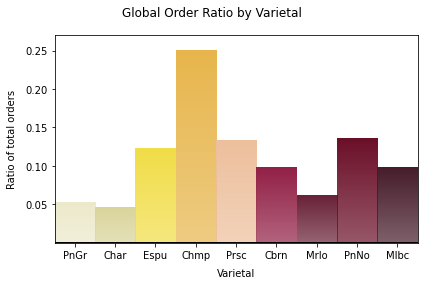

In [35]:
gradient = np.rot90(np.vstack([np.linspace(0, 1, 256), np.linspace(0, 1, 256)]))
fig, ax = plt.subplots(figsize=(6, 4))
global_var_ct = offer_responses.varietal.value_counts(normalize=True)
for (x, v), cmap in zip(enumerate(VARIETALS), GRADS):
    v = global_var_ct.loc[v]
    ax.imshow(gradient, extent=[x - 0.5, x + 0.5, 0, v] , aspect="auto", cmap=cmap, zorder=1)
ax.set_yticks([0.05, 0.1, 0.15, 0.2, 0.25], ['0.05', '0.10', '0.15', '0.20', '0.25']);
ax.set_ylim([0, 0.27]); 
ax.set_ylabel('Ratio of total orders', labelpad=8); ax.set_xlabel('Varietal', labelpad=8)
ax.set_xticks(range(len(VARIETALS)), [varietal_abbrev[v] for v in VARIETALS])
ax.set_xlim([-0.5, len(VARIETALS) -0.5]); ax.axhline(0, lw=2, color='black')
fig.suptitle('Global Order Ratio by Varietal', y=0.98); fig.tight_layout()

Cluster Total Order Ratio by Varietal and Cluster for K in [2, 10]


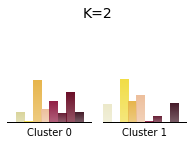

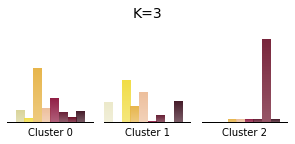

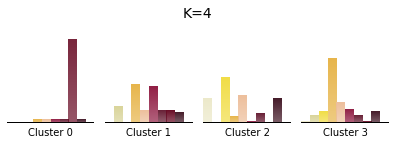

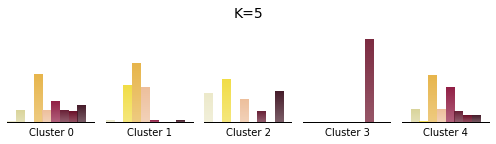

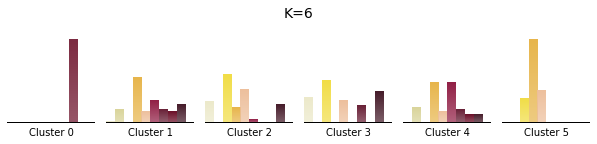

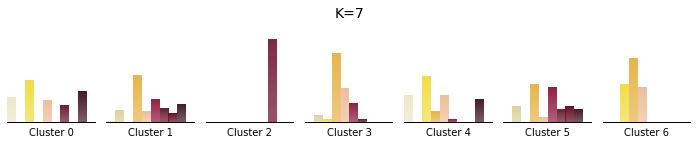

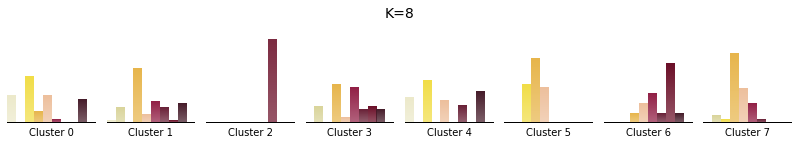

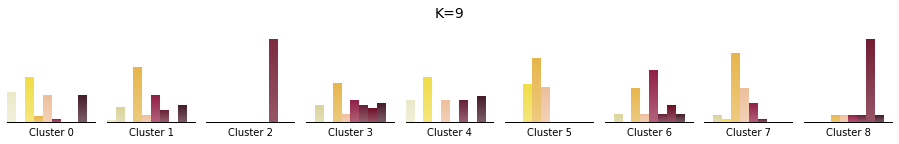

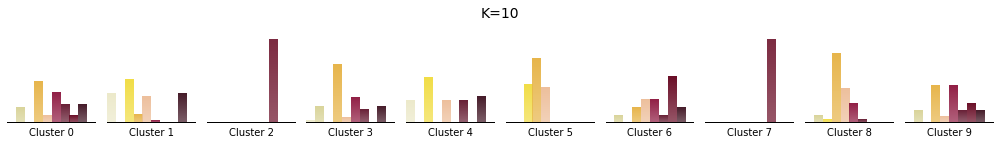

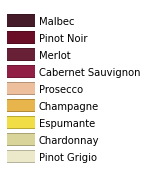

In [36]:
print('Cluster Total Order Ratio by Varietal and Cluster for K in [2, 10]')
for k in k_list:
    fig, axs = plt.subplots(1, k, figsize=(1.4 * k, 2))
    for cluster_id, ax in zip(range(k), axs.flat):
        cluster_varietals = cdf.loc[(k, cluster_id)].varietal.to_list()
        v_counts = [
            cluster_varietals.count(v)/len(cluster_varietals)
            for v in VARIETALS
        ]
        for x, v, cmap in zip(range(len(VARIETALS)), v_counts, GRADS):
            if v == 0:
                continue
            extent = [x - 0.5, x + 0.5, 0, v]
            ax.imshow(gradient, extent=extent , aspect="auto", cmap=cmap, zorder=1)
        ax.set_xticks([], []); ax.set_yticks([], []); ax.set_frame_on(False)
        ax.set_ylim([0, 0.6]); ax.set_xlabel(f'Cluster {cluster_id}')
        ax.set_xlim([-0.5, len(VARIETALS) + 0.5]); ax.axhline(0, lw=2, color='black')
    fig.suptitle(f'K={k}', fontsize=14); fig.tight_layout()
varietal_legend();
plt.show()

At all values of K in the interval `[2, 10]`, at least one cluster is formed such that orders for champagne outnumber those of other individual varietals.<br><br>

For K in the interval `[3, 10]`, at least one cluster represents individuals who ordered mostly Pinot Noir.<br><br>

For K in the interval `[4, 10]`, at least one cluster represents individauls who exclusively ordered Pinot Noir.<br><br>

For K in the interval `[5, 10]`, at least one cluster represents individuals who mostly ordered the effervesenct white wines, Espumante, Prosecco, and Champagne. At `K ≥ 6`, one of the clusters formed rerepresents customers who exlcusively ordrered effervescent white wines.

Construct a sequence of subplots similar to that shown above depicting the difference between order ratios at each cluster and global order ratios.

Cluster Total Order Ratio Less Global Ratio by Varietal and Cluster for K in [2, 10]


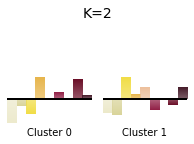

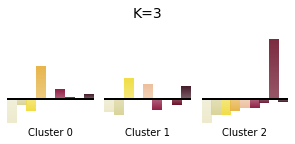

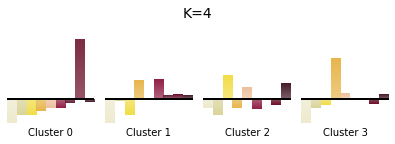

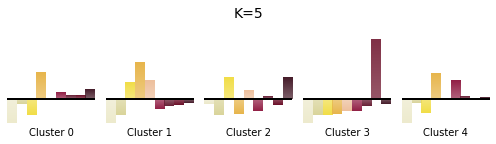

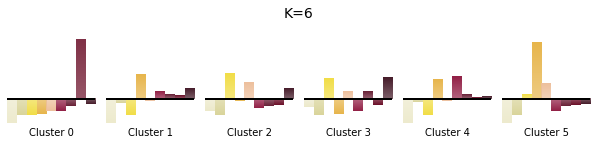

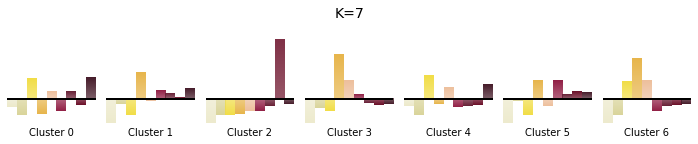

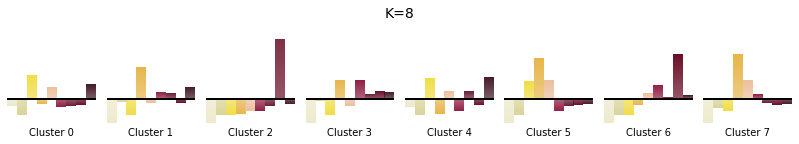

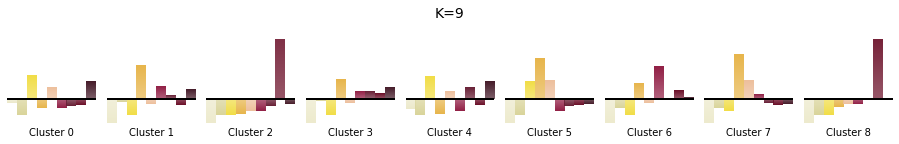

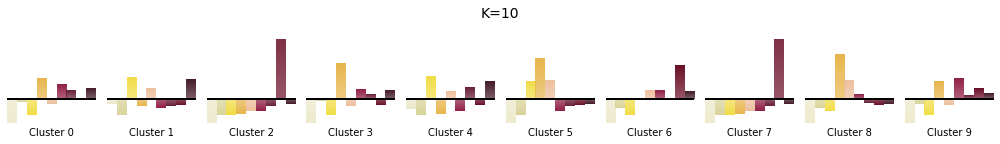

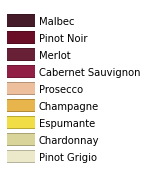

In [37]:
print('Cluster Total Order Ratio Less Global Ratio by '
      + 'Varietal and Cluster for K in [2, 10]')
for k in k_list:
    fig, axs = plt.subplots(1, k, figsize=(1.4 * k, 2))
    for cluster_id, ax in zip(range(k), axs.flat):
        cluster_varietals = cdf.loc[(k, cluster_id)].varietal.to_list()
        v_counts = [
            cluster_varietals.count(v)/len(cluster_varietals)
            for v in VARIETALS
        ]
        delta = np.array(v_counts) - global_var_ct.values
        #for x, v, color in zip(range(len(VARIETALS)), delta, W_COLORS):
            #ax.bar(x=x, height=v, color=color)
        for x, v, cmap in zip(range(len(VARIETALS)), delta, GRADS):
            if v!=0:
                extent = [x - 0.5, x + 0.5, 0, v]
                ax.imshow(gradient, extent=extent , aspect="auto", cmap=cmap, zorder=1)
        #for x, v, cmap in zip(range(len(VARIETALS)), v_counts, GRADS):
            #if v == 0:
                #continue
            #extent = [x - 0.5, x + 0.5, 0, v]
            #ax.imshow(gradient, extent=extent , aspect="auto", cmap=cmap, zorder=1)
        ax.set_xticks([], []); ax.set_yticks([], []); ax.set_frame_on(False)
        ax.set_ylim([-0.2, 0.5]); ax.set_xlabel(f'Cluster {cluster_id}')
        ax.set_xlim([-0.5, len(VARIETALS) - 0.5]); ax.axhline(0, lw=2, color='black')
    fig.suptitle(f'K={k}', fontsize=14); fig.tight_layout()
varietal_legend();
plt.show()


Generate plots to visualize the distribution of the `min_qty` feature in the original data and the clusters formed at each K. Plot global distributions at equal weight by offer, customer, and response. Plot cluster distributions at equal weight by response.

Minimum Order Quantity Ratios by Cluster for K in [2, 10]


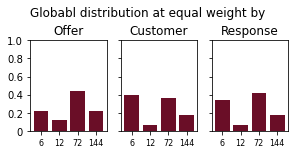

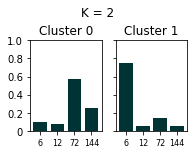

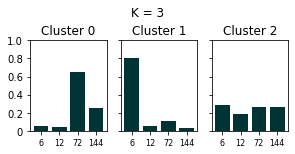

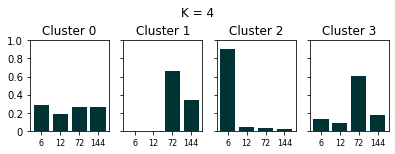

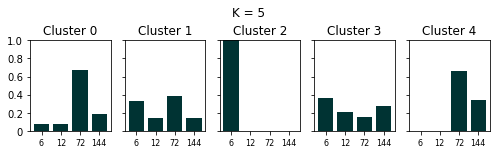

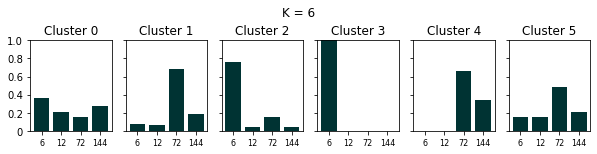

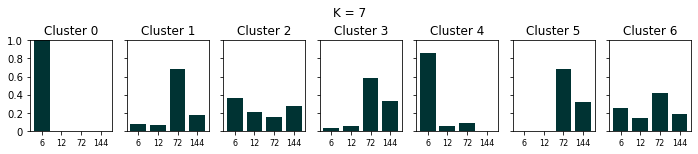

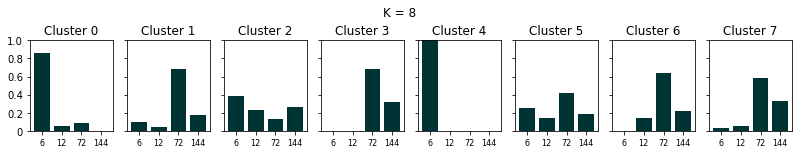

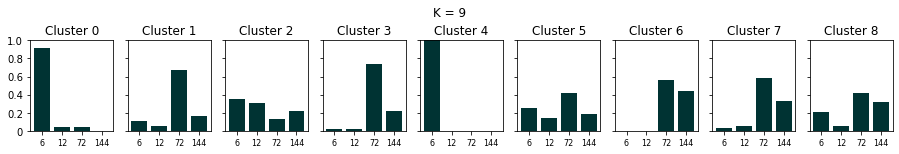

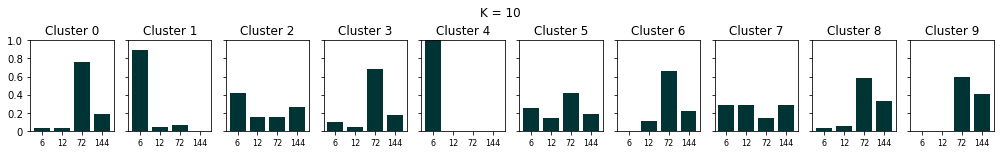

In [38]:
print('Minimum Order Quantity Ratios by Cluster for K in [2, 10]')
min_qs = sorted(offers_by_id.min_qty.unique())
fig, axs = plt.subplots(1, 3, figsize=(3 * 1.4, 2))
global_by_offer = offers_by_id.min_qty.value_counts(normalize=True).reindex(
    min_qs, fill_value=0
)
global_by_customer = (
    trx_by_customer.merge(
        offers_by_id, how='left', left_on='offer_id', right_index=True
    ).drop(columns='n').groupby(['customer_name'])
    .min_qty.value_counts(normalize=True).reset_index(level='customer_name', drop=True)
    .groupby(['min_qty']).sum() / len(x_names)
)
global_by_response = (
    trx_by_customer.merge(
        offers_by_id, how='left', left_on='offer_id', right_index=True
    ).drop(columns='n').min_qty.value_counts(normalize=True).reindex(
        min_qs, fill_value=0
    )
)
for ax, g_df, title in zip(
        axs.flat, [global_by_offer, global_by_customer, global_by_response], 
        ['Offer', 'Customer', 'Response']):
    ax.set_xticks(range(len(min_qs)), min_qs, fontsize=8); ax.set_ylim([0, 1])
    ax.set_title(title); ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['']*6)
    for x, q in enumerate(g_df.values):
        ax.bar(x=x, height=q, color=W_COLORS[-2])
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
fig.tight_layout(); 
fig.suptitle('Globabl distribution at equal weight by', y=1.05);
for k in k_list:
    fig, axs = plt.subplots(1, k, figsize=(1.4 * k, 2))
    k_subset = cdf.loc[k]
    for cluster_id, ax in enumerate(axs.flat):
        cluster_subset = k_subset.loc[cluster_id]
        m_q = cluster_subset.min_qty
        qty = cluster_subset.min_qty.value_counts(normalize=True).reindex(
            min_qs, fill_value=0)
        for x, q in enumerate(qty):
            ax.bar(x=x, height=q, color=[0, 0.2, 0.2])
        ax.set_xticks(range(len(min_qs)), min_qs, fontsize=8); ax.set_ylim([0, 1])
        ax.set_title(f'Cluster {cluster_id}')
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], ['']*6)
    axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
    fig.tight_layout(); fig.suptitle(f'K = {k}', y=1.05);

At all tested values of K, at least one cluster is formed where customers predominantly responded to offers with a minimum order quantity of 6. At `K ≥ 5`, one cluster represents customers who exclusivley responded to orders with a minimum quantity of 6. This cluster is not otherwise associated with any specific varietal, color, effervescence, or combination thereof.

Generate simplified discount ratio plots for global and cluster distributions.

Discount Ratios by Cluster for K in [2, 10]


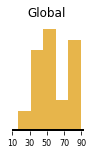

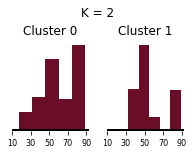

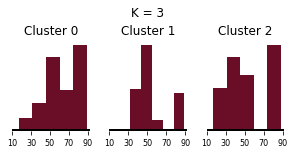

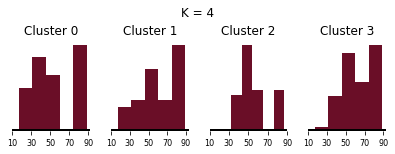

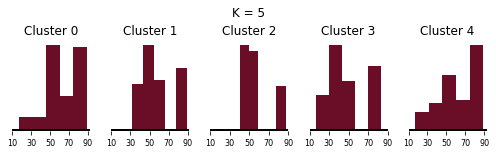

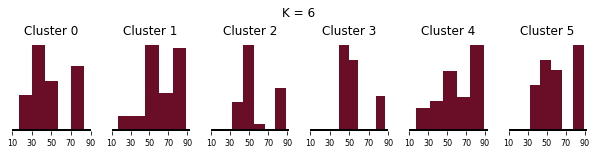

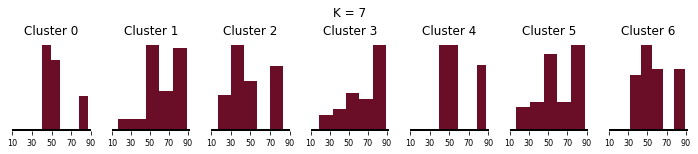

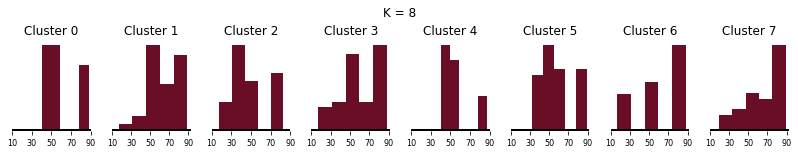

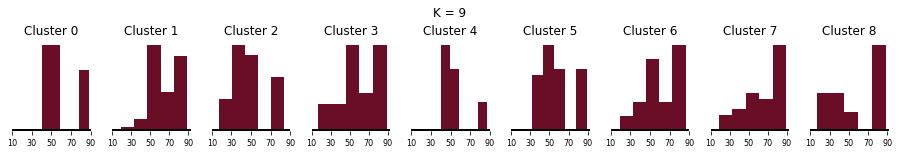

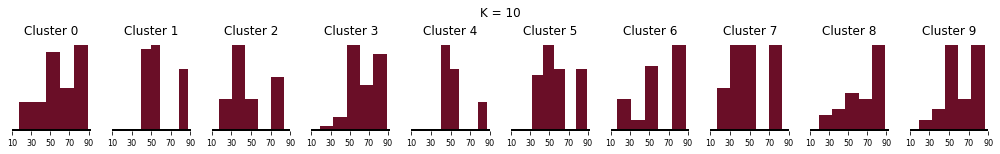

In [39]:
print('Discount Ratios by Cluster for K in [2, 10]')
xt = [10, 30, 50, 70, 90]
discs = sorted(offers_by_id.discount.unique())
fig, ax = plt.subplots(figsize=(1.4, 2))
ax.hist(offers_by_id.discount, bins=5, density=True, color=W_COLORS[3]); 
ax.set_yticks([]); ax.set_xticks(xt, xt, fontsize=8);
ax.set_yticks([]), ax.spines[:].set_color([0, 0, 0, 0])
ax.axhline(0, lw=4, color=[0, 0, 0])
fig.tight_layout(); fig.suptitle(f'Global', y=1.05);
for k in k_list:
    fig, axs = plt.subplots(1, k, figsize=(1.4 * k, 2))
    k_subset = cdf.loc[k]
    for cluster_id, ax in enumerate(axs.flat):
        cluster_subset = k_subset.loc[cluster_id]
        m_d = cluster_subset.discount
        ax.hist(m_d, bins=5, density=True, color=W_COLORS[-2])
        ax.set_xticks(xt, xt, fontsize=8);
        ax.set_title(f'Cluster {cluster_id}')
        ax.tick_params(axis='y', which='both', length=0)
        ax.set_yticks([]), ax.spines[:].set_color([0, 0, 0, 0])
        ax.axhline(0, lw=4, color=[0, 0, 0])
    fig.tight_layout(); fig.suptitle(f'K = {k}', y=1.05);
plt.show()

Cluster Discount Ratios less Global Discount Ratios by Cluster for K in [2, 10]


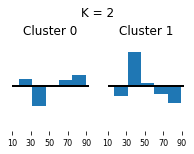

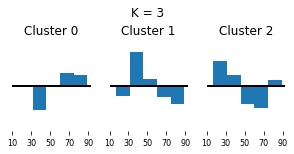

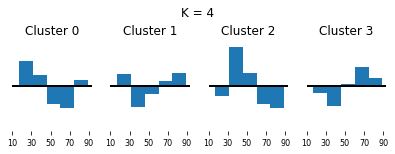

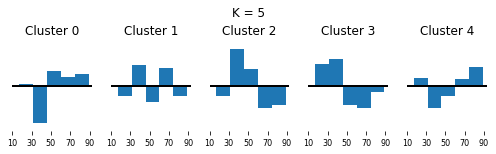

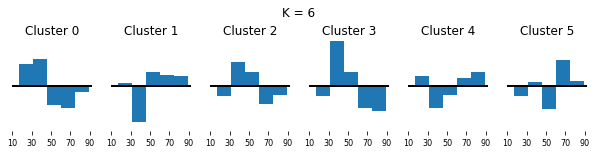

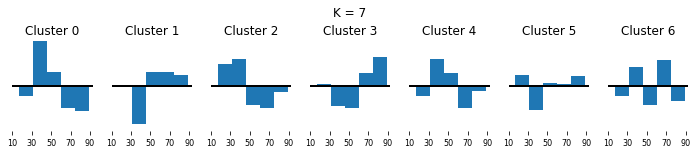

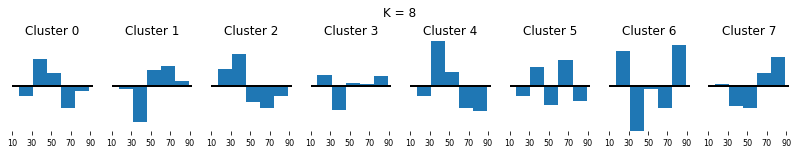

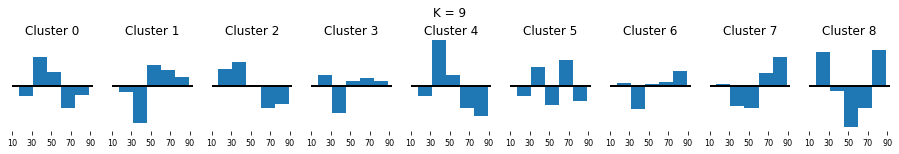

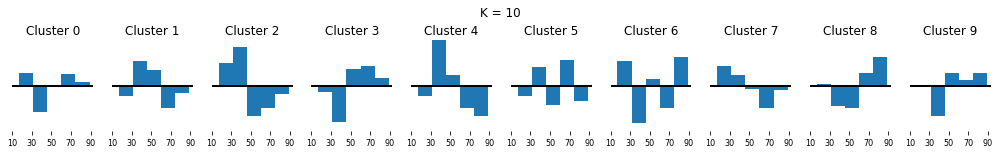

In [40]:
disc_global, bins = np.histogram(offer_responses.discount, bins=5, density=True)
for k in k_list:
    fig, axs = plt.subplots(1, k, figsize=(1.4 * k, 2))
    k_subset = cdf.loc[k]
    for cluster_id, ax in enumerate(axs.flat):
        cluster_subset = k_subset.loc[cluster_id]
        m_d, _ = np.histogram(cluster_subset.discount, density=True, bins=bins)
        m_d -= disc_global
        ax.bar(x=bins[:-1], height=m_d, align='edge', width=bins[1:] - bins[:-1])
        ax.set_xticks(xt, xt, fontsize=8)
        ax.set_title(f'Cluster {cluster_id}')
        ax.tick_params(axis='y', which='both', length=0)
        ax.set_yticks([]), ax.spines[:].set_color([0, 0, 0, 0])
        ax.axhline(0, lw=2, color=[0, 0, 0]); ax.set_ylim([-0.015, 0.015])
    fig.tight_layout(); fig.suptitle(f'K = {k}', y=1.05)
print('Cluster Discount Ratios less Global Discount Ratios by Cluster for K in [2, 10]')

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

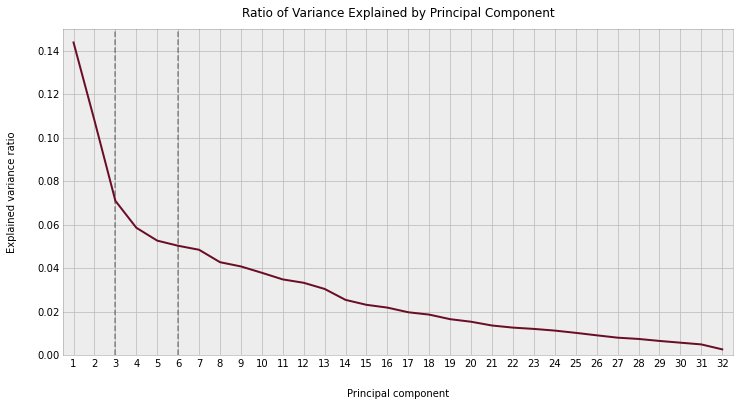

In [41]:
X = x_cols
pca = PCA()
pca.fit(X)
pc_nums = np.arange(1, pca.n_components_ + 1)
pc_var_ratio = pca.explained_variance_ratio_
pc_var_slope = np.hstack(([0], np.diff(pc_var_ratio)))
pc_var_accel = np.hstack(([0, 0], np.diff(pc_var_slope[1:])))
fig, ax = plt.subplots(figsize=(12,6)); ax.grid(color=(0.75, 0.75, 0.75), zorder=1)
ax.tick_params(axis='both', which='both', length=0)
ax.plot(pc_nums, pc_var_ratio, lw=2, zorder=3, color=W_COLORS[-2])
for point in [3, 6]:
    ax.axvline(point, ls='--', color=[0, 0, 0, 0.4])
ax.set_xticks(pc_nums, labels=pc_nums); ax.set_xlim(0.5, 32.5)
ax.set_xlabel('Principal component', labelpad=20)
ax.set_ylabel('Explained variance ratio', labelpad=20)
ax.set_title('Ratio of Variance Explained by Principal Component', pad=12);
ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0.5])
ax.set_ylim(0, 0.15); ax.set_facecolor([0.93, 0.93, 0.93]);

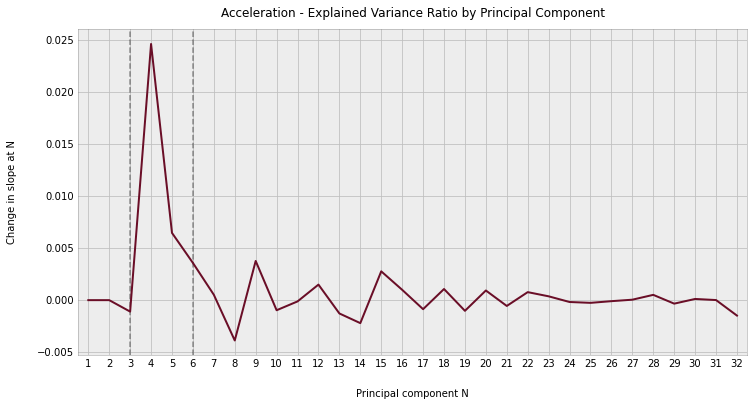

In [42]:
fig, ax = plt.subplots(figsize=(12,6)); ax.grid(color=(0.75, 0.75, 0.75), zorder=1)
ax.tick_params(axis='both', which='both', length=0)
ax.plot(pc_nums, pc_var_accel, lw=2, zorder=3, color=W_COLORS[-2])
for point in [3, 6]:
    ax.axvline(point, ls='--', color=[0, 0, 0, 0.4])
ax.set_xticks(pc_nums, labels=pc_nums); ax.set_xlim(0.5, 32.5)
ax.set_xlabel('Principal component N', labelpad=20)
ax.set_ylabel('Change in slope at N', labelpad=20)
ax.set_title('Acceleration - Explained Variance Ratio by Principal Component', pad=12);
ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0.5])
ax.set_facecolor([0.93, 0.93, 0.93]);

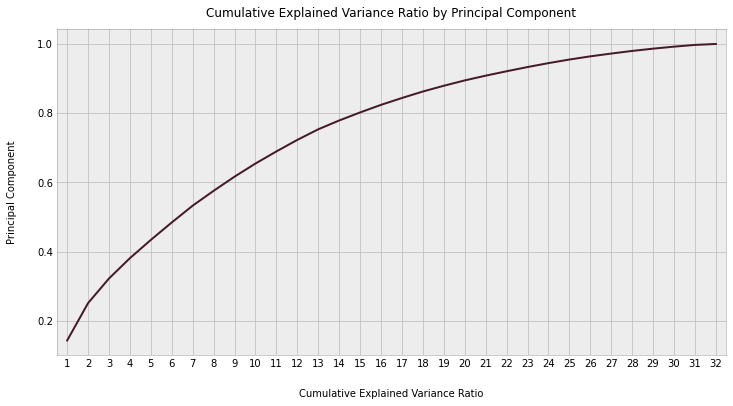

In [43]:
fig, ax = plt.subplots(figsize=(12,6)); ax.grid(color=(0.75, 0.75, 0.75), zorder=1)
ax.tick_params(axis='both', which='both', length=0)
ax.set_facecolor([0.93, 0.93, 0.93]); ax.spines[:].set_edgecolor([0.5, 0.5, 0.5, 0.5])
ax.plot(pc_nums, np.cumsum(pc_var_ratio), lw=2, zorder=3, color=W_COLORS[-1])
ax.set_title(
    'Cumulative Explained Variance Ratio by Principal Component', 
    pad=12
)
ax.set_xlabel('Cumulative Explained Variance Ratio', labelpad=20);
ax.set_ylabel('Principal Component', labelpad=20)
ax.set_xticks(range(1, 33), range(1, 33)); ax.set_xlim([0.5, 32.5]);

In [44]:
optimal_k = pd.Series(pc_var_accel).idxmax()
print(f'Optimal dimensions\n{hr("-", newline=False)}')
print(f'{"metric:":<8} acceleration of explained'
      + ' variance ratio by principal component')
print(f'{"value:":<8} {optimal_k}')

Optimal dimensions
-------------------------------------------------------------------------------
metric:  acceleration of explained variance ratio by principal component
value:   3


Using the provided `pca` model, the greatest changes in slope of the plot of explained variance ratio by principal component occur between the principal component pairs `[2, 3]` and `[6, 7]`. A local minimum slope occurs in the principal component interval `[5, 7]`. <br><br>
Elbow methods rely on subjective interpretations of the apparent slope and acceleration of explained variance plots; a "true" elbow cannot exist.<br><br>
To select an optimal value for `n_components`, I would test clusterings performed on PCA transformations of features for `n_components` values between 3 and 7. Broadly, the specific number of components selected would depend on the objectives and outcomes of clustering. In the context of this notebook, the business problem and clustering objectives are too vague to allow confident selction by these methods. I arbitrarily select 4 as an optimal number of components for the PCA transformation of these unstandardized (though inherently min-max scaled) input features. <br><br>

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p></p>
</div>


Generate required inputs for clusterers.

In [45]:
x_data = trx_by_customer.merge(
    offers_by_id, how='left', left_on='offer_id', right_index=True
).reset_index()
x_data.drop(columns='n', inplace=True)
affinity, spectral, agglomerative, dbscan = (
    AffinityPropagation(), SpectralClustering(), 
    AgglomerativeClustering(), DBSCAN()
)

Initialize a clusterer with default arguments for each of the above-mentioned clustering methods. For `n` in the interval `[2, 10]`, calculate average silhouette scores for clusters generated by fitting each clusterer to principal components in the interval `[1, n]`. Map these silhouette scores to interpretations provided earlier in this notebook.

In [46]:
print('Optimal n_components by clustering method (default parameters)\n'
      +'metric: cluster average silhouette score\n'
      +f'{hr("-", newline=0)}')
silh_scores_at_n = pd.DataFrame(
    index=['affinity propagation', 'spectral', 'agglomerative', 'DBSCAN'], 
    columns=[f'{i}' for i in range(2, 11)]
)
for n in range(2, 11):
    pca_n = PCA(n_components=n)
    X_n = pca_n.fit_transform(X)
    affinity, spectral, agglomerative, dbscan = [
        AffinityPropagation(), SpectralClustering(), 
        AgglomerativeClustering(), DBSCAN()
    ]
    clustering_methods = [affinity, spectral, agglomerative, dbscan]
    cluster_options = ClusteringOptionGroup(
        X_n, x_names, 'customer_name', x_data, clustering_methods,
        ['affinity propagation', 'spectral', 'agglomerative', 'DBSCAN']
    )
    for name, model in cluster_options.op_items:
        if len(set(model.labels)) < 2:
            silh_scores_at_n.loc[name, f'{n}'] = -99
            continue
        silh_scores_at_n.loc[name, f'{n}'] = round(model.avg_silhouette_score, 4)
for method, scores in silh_scores_at_n.iterrows():
    print(f'{method:<20}{scores.astype(float).idxmax():>6}{" components"}')

silh_assessment = silh_scores_at_n.max(axis=1).to_frame().rename(columns={0:'score'})
silh_assessment['structure'] = silh_assessment.score.map(interpret_silh_score)
silh_assessment


Optimal n_components by clustering method (default parameters)
metric: cluster average silhouette score
-------------------------------------------------------------------------------
affinity propagation     2 components
spectral                 2 components
agglomerative            2 components
DBSCAN                   4 components


,score,structure
affinity propagation,0.5057,weak
spectral,0.4094,weak
agglomerative,0.4107,weak
DBSCAN,0.2680,weak


Given default settings and a range of PCA components as inputs, none of the average silhouette scores returned by each clustering method indicates "high quality" clustering.

Assign a `PCA` instance with `n_components=3` to a variable. Use these components to fit clusterers for each method.  Assign the first two principal components to variables as separate arrays to enable visualization of clusters in the feature space defined by these components.

In [47]:
pca = PCA(n_components=3)
pca_x = pca.fit_transform(X)
pca_1, pca_2 = pca_x[:, 0], pca_x[:, 1]

#### Affinity Propagation

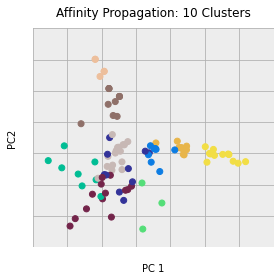

In [48]:
affinity = AffinityPropagation()
affinity.fit(pca_x); n_c = len(set(affinity.labels_))
clustering_scatterplot(pca_1, pca_2, affinity.labels_, n_c, 
                       title=f'Affinity Propagation: {n_c} Clusters');

#### Spectral Clustering

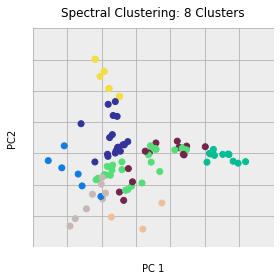

In [49]:
spectral = SpectralClustering()
spectral.fit(pca_x); n_c = len(set(spectral.labels_))
clustering_scatterplot(pca_1, pca_2, spectral.labels_, n_c,
                       title=f'Spectral Clustering: {n_c} Clusters');

#### Agglomerative Clustering

Plot a dendrogram of an `AgglomerativeClustering` instance fit to the PCA-transformed features.

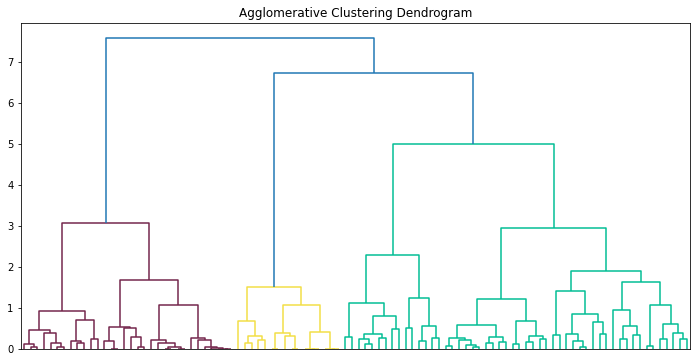

In [50]:
agglom = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agglom.fit(pca_x)
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Agglomerative Clustering Dendrogram')
dendrogram_from_clusterer(agglom, ax=ax); ax.set_xticks([]);

Use the dendrogram above to select a range of `n_cluster` candidates to assess using average silhouette scores.

In [51]:
agglom_scores = {'clusters': [], 'silhouette score': []}
for t in range(2, 12):
    t_labels = fcluster(Z=linkage_matrix(agglom), t=t, criterion='maxclust')
    silh = silhouette_score(X=pca_x, labels=t_labels)
    agglom_scores['silhouette score'].append(silh)
    agglom_scores['clusters'].append(t)
agglom_scores = pd.DataFrame(agglom_scores)
agglom_scores.loc[:, 'clusters'] = agglom_scores.loc[:, 'clusters'].astype(int)
agglom_scores.set_index('clusters', inplace=True)
n_cl_w_max_silh = agglom_scores.idxmax().values[0]
print('Agglomerative clustering:\naverage silhouette score by number of clusters')
print(f'max silhouette score at n_clusters = {n_cl_w_max_silh}')
agglom_scores.T

Agglomerative clustering:
average silhouette score by number of clusters
max silhouette score at n_clusters = 4


clusters,2,3,4,5,6,7,8,9,10,11
silhouette score,0.314028,0.416646,0.435497,0.397316,0.353726,0.378785,0.384188,0.386753,0.39661,0.376692


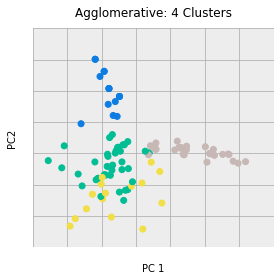

In [52]:
fig, ax = plt.subplots(figsize=(4, 4))
agglom_labels = fcluster(Z=linkage_matrix(agglom), t=n_cl_w_max_silh, criterion='maxclust')
clustering_scatterplot(pca_1, pca_2, labels=agglom_labels, n=n_cl_w_max_silh, ax=ax, 
                       title=f'Agglomerative: {n_cl_w_max_silh} Clusters');

#### DBSCAN

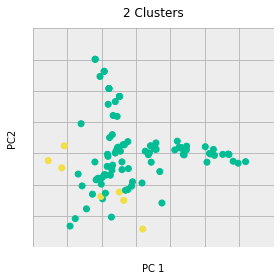

In [53]:
dbscan = DBSCAN()
dbscan.fit(pca_x)
dbscan_labels = dbscan.labels_; dbscan_n = len(set(dbscan.labels_))
dbscan_labels = [_ + 4 for _ in dbscan_labels]
clustering_scatterplot(pca_1, pca_2, labels=dbscan_labels, n=dbscan_n)


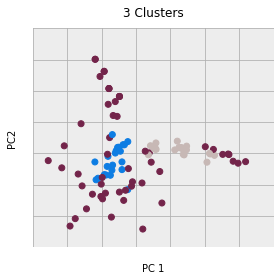

In [54]:
dbscan = DBSCAN(eps=0.45, min_samples=15)
dbscan_labels = dbscan.fit_predict(pca_x)
dbscan_labels = [_ + 1 for _ in dbscan_labels]
clustering_scatterplot(pca_1, pca_2, dbscan_labels, len(set(dbscan_labels)))